## Part 1. Simulator 2D
In this part, we try to model a real Poisson process. Actually it should be several Poisson processes with different parameters. For each random process, we use exponential distribution to model the waiting time between events (transcription) and generate a sequence of time steps when the event happens.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math
import time
import bisect
from IPython.display import display, clear_output
%matplotlib inline


def scheduler(T, lambdas):
    # Firstly, split the whole timeline into sevaral parts
    num_intervals = len(lambdas)
    interval_len = int(T / num_intervals)
    intervals = np.full(num_intervals-1, interval_len)
    split_points = np.cumsum(intervals)
    # decide the waiting time by the given lambda
    cumu_time = 0
    happen_time_step = [] # each element means at what time does an event happens
    while cumu_time < T:
        select = 0
        if cumu_time > split_points[-1]:
            select = num_intervals - 1
        else:
            for i in range(num_intervals-2):
                if split_points[i] < cumu_time < split_points[i+1]:
                    select = i+1
                    break
        lam = lambdas[select]
        wait = np.random.exponential(scale = 1/lam)
        cumu_time += wait
        happen_time_step.append(cumu_time)
    return happen_time_step[:-1]

class Molecule:
    def __init__(self, id, velocity, sigma, t):
        self.id = id
        self.born_time = t
        self.distance = 0
        self.velocity = velocity
        self.sigma = sigma
        self.direction = np.random.uniform(0, math.pi * 2, size=1)


class Cell:
    def __init__(self):
        self.center = (0.5, 0.5)
        self.radius = 0.5
        self.molecules = []
        self.maxid = 0
        self.resolution = 0.1
        self.degrade_rate = 0.5
        # self.velocity = np.random.uniform(0.001, 0.02)
        # self.sigma = np.random.uniform(0, 0.01)
        self.velocity = 0.05
        self.sigma = 0.01

    def transcription(self, t):
        molecule = Molecule(self.maxid+1, self.velocity, self.sigma, t)
        self.molecules.append(molecule)
        self.maxid += 1

    def diffuse(self, t, schedule):
        # Find the sublist of shcedule with values between (t-resolution) ~ t
        left_index = bisect.bisect_left(schedule, t-self.resolution)
        right_index = bisect.bisect_left(schedule, t)
        generated = schedule[left_index:right_index]
        for t in generated:
            self.transcription(t)
        # Diffusion
        for molecule in self.molecules:
            location = molecule.velocity * (t - molecule.born_time)
            molecule.distance = np.random.normal(location, molecule.sigma)
            molecule.direction = np.random.normal(molecule.direction, 0.01)

    def degrade(self):
        degrade_list = []
        for molecule in self.molecules:
            if molecule.distance > 0.9 * self.radius:
                hit = np.random.binomial(1, self.degrade_rate)
                if hit == 1:
                    degrade_list.append(molecule.id)
        self.molecules = [molecule for molecule in self.molecules if molecule.id not in degrade_list]

    def plotcell(self):
        circle = Circle(self.center, self.radius, fill=False)
        num_molecules = len(self.molecules)
        fig, ax = plt.subplots()
        ax.add_patch(circle)
        ax.set_aspect('equal')
        ax.plot(self.center[0], self.center[1], 'ro')
        for molecule in self.molecules:
            dist = molecule.distance
            angle = molecule.direction
            x = dist * math.cos(angle) + self.center[0]
            y = dist * math.sin(angle) + self.center[1]
            ax.plot(x, y, 'bo')
        plt.show()

    def plot_dynamic(self, T, schedule):
        # initiate the cell and nuclei
        circle = Circle(self.center, self.radius, fill=False)
        fig, ax = plt.subplots(figsize=(8,8))
        ax.add_patch(circle)
        ax.set_aspect('equal')
        ax.plot(self.center[0], self.center[1], 'ro')
        # run the diffusion process and save points at each time step
        x_data = np.zeros(0)
        y_data = np.zeros(0)
        sc = ax.scatter(x_data, y_data)
        time_steps = np.arange(0, T, self.resolution)
        for t in range(1, time_steps.shape[0]):
            self.diffuse(time_steps[t], schedule)
            self.degrade()
            num_molecules = len(self.molecules)
            x_data = np.zeros(num_molecules)
            y_data = np.zeros(num_molecules)
            for i in range(num_molecules):
                dist = self.molecules[i].distance
                angle = self.molecules[i].direction
                x = dist * math.cos(angle) + self.center[0]
                y = dist * math.sin(angle) + self.center[1]
                x_data[i] = x
                y_data[i] = y
            # dynamically plot the diffusion process
            sc.set_offsets(np.column_stack((x_data, y_data)))  # Update scatter plot data
            ax.set_title(f'Iteration {t+1}')
            display(fig)
            time.sleep(0.1)
            clear_output(wait=True)

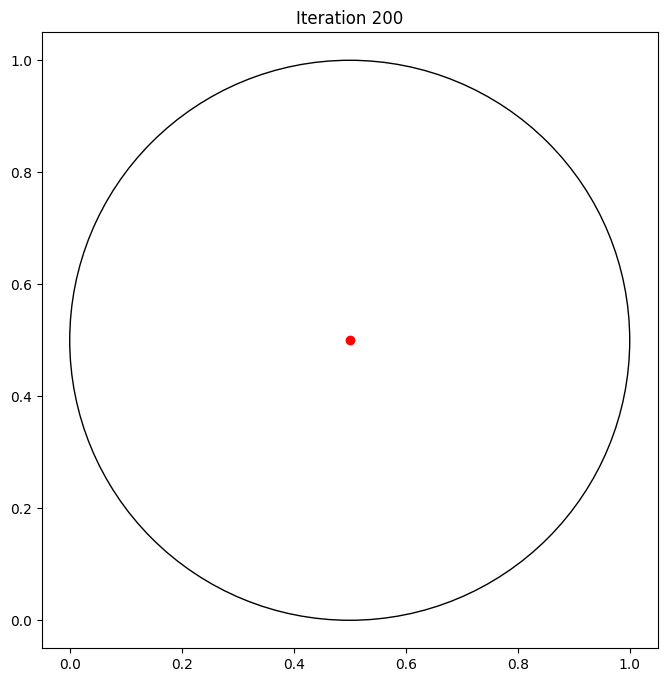

In [6]:
cell1 = Cell()
T = 20
rates = [3, 0.001, 3]
schedule = scheduler(T, rates)
cell1.plot_dynamic(T, schedule)

## Part 2. Simulator 3D
In this part, we try to model a heterogeneous Poisson process with any possible functions of the parameter $\lambda$ in 3D space.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
import time
import bisect
from IPython.display import display, clear_output
%matplotlib inline


def scheduler(T, rate_list, resolution):
    upper_bound_rate = np.max(rate_list)
    cumu_time = 0
    happen_time_step = [] # each element means at what time does an event happens
    while cumu_time < T:
        wait = np.random.exponential(scale=1/upper_bound_rate)
        cumu_time += wait
        happen_time_step.append(cumu_time)
    happen_time_step = np.array(happen_time_step)
    accept = np.zeros_like(happen_time_step)
    for i in range(happen_time_step.shape[0]):
        t = happen_time_step[i]
        step = int(t / resolution)
        if step >= len(rate_list):
            step = len(rate_list) - 1
        rate = rate_list[step]
        if np.random.uniform(0, 1) < rate / upper_bound_rate:
            accept[i] = 1
    return happen_time_step[accept==1]


def plotcell(states, center):
    # figure initialization
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.plot(0, 0, 0, 'ro')
    x_data = np.zeros(0)
    y_data = np.zeros(0)
    z_data = np.zeros(0)
    sc = ax.scatter(x_data, y_data, z_data)
    # plot states at all the time steps
    for t in range(len(states)):
        molecules = states[t]
        num_molecules = len(molecules)
        x_data = np.zeros(num_molecules)
        y_data = np.zeros(num_molecules)
        z_data = np.zeros(num_molecules)
        for i in range(num_molecules):
            x_data[i], y_data[i], z_data[i], _ = molecules[i]
        # dynamically plot the diffusion process
        sc._offsets3d = (x_data, y_data, z_data)  # Update scatter plot data
        ax.set_title(f'Iteration {t+1}')
        display(fig)
        time.sleep(0.2)
        clear_output(wait=True)


def build_data(states, radius, num_dists):
    num_steps = len(states)
    data = np.zeros((num_steps, num_dists))
    stride = radius / data.shape[1]
    for i in range(num_steps):
        molecules = states[i]
        for m in range(len(molecules)):
            x, y, z, dist = molecules[m]
            j = int(dist / stride)
            data[i][j] += 1
    return data


class Molecule:
    def __init__(self, id, velocity, sigma, t):
        self.id = id
        self.born_time = t
        self.distance = 0
        self.velocity = velocity
        self.sigma = sigma
        self.phi = np.random.uniform(0, math.pi * 2, size=1)  # z-axis angle
        self.theta = np.random.uniform(0, math.pi * 2, size=1)# xy-axis angle


class Cell:
    def __init__(self, center, radius, resolution, velo, brownian):
        self.center = center
        self.radius = radius
        self.molecules = []
        self.maxid = 0
        self.resolution = resolution
        self.degrade_rate = 0.5
        # self.velocity = np.random.uniform(0.001, 0.02)
        # self.sigma = np.random.uniform(0, 0.01)
        self.velocity = velo
        self.sigma = brownian
        self.trajectory = []

    def transcription(self, t):
        molecule = Molecule(self.maxid+1, self.velocity, self.sigma, t)
        self.molecules.append(molecule)
        self.maxid += 1

    def diffuse(self, t, schedule):
        # Find the sublist of shcedule with values between (t-resolution) ~ t
        left_index = bisect.bisect_left(schedule, t-self.resolution)
        right_index = bisect.bisect_left(schedule, t)
        generated = schedule[left_index:right_index]
        for t in generated:
            self.transcription(t)
        # Diffusion
        for molecule in self.molecules:
            location = molecule.velocity * (t - molecule.born_time)
            molecule.distance = np.random.normal(location, molecule.sigma)
            molecule.phi = np.random.normal(molecule.phi, 0.01)
            molecule.theta = np.random.normal(molecule.theta, 0.01)

    def degrade(self):
        degrade_list = []
        for molecule in self.molecules:
            if molecule.distance > 0.9 * self.radius:
                hit = np.random.binomial(1, self.degrade_rate)
                if hit == 1:
                    degrade_list.append(molecule.id)
        self.molecules = [molecule for molecule in self.molecules if molecule.id not in degrade_list]

    def dynamic(self, T, schedule):
        # run the diffusion process and save points at each time step
        x_data = np.zeros(0)
        y_data = np.zeros(0)
        z_data = np.zeros(0)
        time_steps = np.arange(0, T, self.resolution)
        # self.trajectory.append(self.molecules)
        for t in range(time_steps.shape[0]):
            self.diffuse(time_steps[t], schedule)
            self.degrade()
            # self.trajectory.append(self.molecules) # record the current state
            num_molecules = len(self.molecules)
            x_data = np.zeros(num_molecules)
            y_data = np.zeros(num_molecules)
            z_data = np.zeros(num_molecules)
            state = []
            for i in range(num_molecules):
                dist = self.molecules[i].distance
                phi = self.molecules[i].phi
                theta = self.molecules[i].theta
                x = dist * math.sin(phi) * math.cos(theta) + self.center[0]
                y = dist * math.sin(phi) * math.sin(theta) + self.center[1]
                z = dist * math.cos(phi) + self.center[2]
                x_data[i] = x
                y_data[i] = y
                z_data[i] = z
                state.append((x, y, z, dist))
            self.trajectory.append(state)

In [13]:
# set the hyper-parameters
resolution = 0.1    # difference between two time steps
center = (0, 0, 0)
radius = 5
velocity = 0.1
brownian = 0.05
# set the total time and transcription rates for each interval
T = 20
rates = [10]*30 + [0]*70 + [10]*100 
# rates = [5]*120 + [0]*80
schedule = scheduler(T, rates, 0.1)
# generate data
num_samples = 200
num_dists = 50
data = []
cells = []
for i in range(num_samples):
    print(f"\rProgress: {i+1}", end='', flush=True)
    cell = Cell(center, radius, resolution, velocity, brownian)
    cell.dynamic(T, schedule)
    # plotcell(cell.trajectory, center)
    cells.append(cell)
    sample = build_data(cell.trajectory, radius, num_dists)
    data.append(sample.flatten())

Progress: 2

/var/folders/vr/79q78d855s91mbd85bq9hf3xg0x6wx/T/ipykernel_2476/1286925038.py:149: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = dist * math.sin(phi) * math.cos(theta) + self.center[0]
/var/folders/vr/79q78d855s91mbd85bq9hf3xg0x6wx/T/ipykernel_2476/1286925038.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = dist * math.sin(phi) * math.sin(theta) + self.center[1]
/var/folders/vr/79q78d855s91mbd85bq9hf3xg0x6wx/T/ipykernel_2476/1286925038.py:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this 

Progress: 200

In [14]:
data = np.array(data)
np.savetxt("../Simulation/data/simu6.csv", data, delimiter=',')